In [1]:
import numpy as np
import pandas as pd
import os
import time
import numpy as np
import matplotlib.pyplot as plt
os.getcwd()
os.chdir('C:\\Users\\Wetauzer\\Desktop\\Data')

In [2]:
tx_df = pd.read_csv('Z:03_22_03_26.csv')
tx_df = tx_df.sort_values('block_number')

In [3]:
# This is just for selecting subset of blocks. Comment out if you want the whole dataset
num_blocks = 2000
tx_df = tx_df[tx_df.block_number.isin(range(tx_df.block_number.min(), tx_df.block_number.unique()[num_blocks]))]

In [4]:
tx_df.reset_index(inplace=True)
tx_df = tx_df.loc[:, tx_df.columns.intersection(['block_number', 'hash', 'gas_price', 'receipt_gas_used'])]
tx_df.gas_price = tx_df.gas_price/1e9 # convert the prices to gwei

Geth price oracle offers a single price recommendation that is calculated based from the 60th percentile of the minimum accepted bid price from the previous 100 blocks.

In [5]:
def geth_price(tx_df, window = 100):
    """ Function that provides a price recommendation based on the Geth price oracle"""
    blx_in = pd.Series(tx_df["block_number"].unique()) # blocks from our dataset
    blx_out = blx_in[range(window, len(blx_in))] # blocks that will have values
    blk_mins = tx_df.groupby(tx_df.block_number).gas_price.min()
    price_rec = []
    win_min = 0
    win_max = window
    for blk in blx_out:
        blk_win = blk_mins[win_min:win_max]
        price_rec.append(blk_win.quantile(.6))
        win_min += 1
        win_max += 1
    blk_oracle_df = pd.DataFrame({'block_number':blx_out, 'price_rec': price_rec})
    tx_oracle_df = pd.merge(tx_df, blk_oracle_df, how="right", on=["block_number"])
    return tx_oracle_df

In [6]:
# A lot of zero/low gas price txs need to be removed 
tx_exc_low = tx_df[tx_df.gas_price>50]
# tx_df with geth price recommendations
geth_df = geth_price(tx_exc_low)
# Normalize bids based on the Geth price recommendation to get value
geth_df['value'] = geth_df.gas_price / geth_df.price_rec

<AxesSubplot:ylabel='Frequency'>

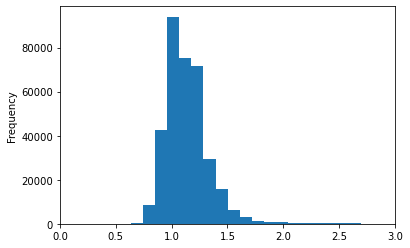

In [7]:
# Distribution of values based on Geth oracle
geth_df.value.plot.hist(xlim = [0, 3], bins = 2000)

<AxesSubplot:ylabel='Frequency'>

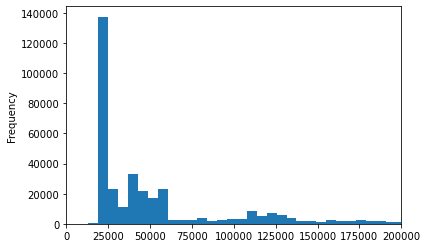

In [8]:
# Distribution of Gas limits
geth_df.receipt_gas_used.plot.hist(xlim = [0, 200000], bins = 2000)

Below is the alternative price oracle which produced quartiles for each block based on all transactions from the past N blocks

In [9]:
def percentile_prices_tx(tx_df, q_1 = 25, q_2 = 50, q_3 = 75, window = 25):
    blx_in = pd.Series(tx_df["block_number"].unique()) # blocks from our dataset
    blx_out = blx_in[range(window, len(blx_in))] # blocks that will have values
    win_min = 0
    win_max = window
    p1 = []
    p2 = []
    p3 = []
    p4 = []
    p5 = []
    for blk in blx_out:
        blk_win = blx_in[win_min:win_max]
        p1.append(tx_df[tx_df.block_number.isin(blk_win)].gas_price.min())
        p2.append(tx_df[tx_df.block_number.isin(blk_win)].gas_price.quantile(q_1/100))
        p3.append(tx_df[tx_df.block_number.isin(blk_win)].gas_price.quantile(q_2/100))
        p4.append(tx_df[tx_df.block_number.isin(blk_win)].gas_price.quantile(q_3/100))
        p5.append(tx_df[tx_df.block_number.isin(blk_win)].gas_price.max())
        win_min += 1
        win_max += 1
    blk_oracle_df = pd.DataFrame({'block_number':blx_out, 'minimum':p1, 'q_1':p2, 'q_2':p3, 'q_3':p4, 'maximum':p5})
    tx_oracle_df = pd.merge(tx_df, blk_oracle_df, how="right", on=["block_number"])
    return tx_oracle_df

In [10]:
percentile_df = percentile_prices_tx(tx_exc_low)

In [11]:
# Function to rescale values to values between 0 and 1
def bids_std(tx):
    gp = tx[3]
    min_p = tx[4]
    max_p = tx[8]
    value = (gp - min_p)/(max_p - min_p)
    return value

In [12]:
# Applying function to df
percentile_df['value'] = percentile_df.apply(bids_std, axis=1)

<AxesSubplot:ylabel='Frequency'>

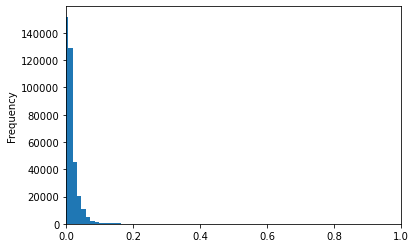

In [19]:
# Distribution of scaled values 
percentile_df.value.plot.hist(xlim = [0,1], bins = 750)